# Theft Data from BikeMaps.Org, Victoria BC

## Part I Importing Libraries and Data Exploration

In [77]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

import numpy as np
import pysal
import pysal.spatial_dynamics.interaction as interaction
np.random.seed(100)
import datetime


from IPython.display import IFrame, Image, HTML, display, YouTubeVideo
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns  # Makes for nicer plots
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4
from matplotlib.patches import Ellipse, Circle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import interact, interactive, fixed

import scipy
import treelib
import pyclust
from scipy.spatial.distance import squareform, pdist
import sklearn
from sklearn import preprocessing


from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler



import shapely
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point


import os
import geopandas as gpd
import matplotlib.pyplot as plt
import mplleaflet

In [78]:
theft = pd.read_csv('/Users/marthamorrissey/Documents/STA_project_MM/Data/theft.csv')

In [79]:
theft.dtypes

i_type                  object
date                    object
p_type                  object
details                 object
how_locked              object
lock                    object
locked_to               object
lighting               float64
traffic                 object
police_report           object
police_report_num       object
insurance_claim         object
insurance_claim_num    float64
regular_cyclist         object
pk                       int64
longitude              float64
latitude               float64
dtype: object

## Exploratory Visualizations

### Location in Space

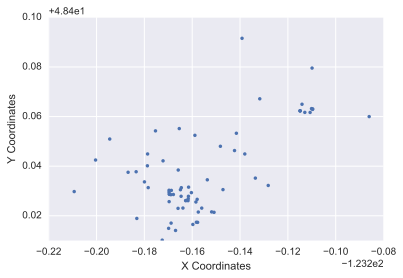

,i_type,date,p_type,details,how_locked,lock,locked_to,lighting,traffic,police_report,police_report_num,insurance_claim,insurance_claim_num,regular_cyclist,pk,longitude,latitude
0,Minor bike component,2015-06-29T19:30:00,theft,Quick release removed from back wheel - i.e. i...,Frame and tire locked,U-Lock,Good,NaN,Medium,True,T15000455,False,NaN,Y,1253,-123.386807,48.437529
1,Bike (value < $1000),2015-07-28T02:00:00,theft,Bike stolen from under the Petch Building bree...,Frame locked,Cable lock,Moderate,NaN,Very Low,True,NaN,False,NaN,Y,1421,-123.310697,48.461660
2,Minor bike component,2015-07-24T21:30:00,theft,Bike helmet stolen. It was not locked.,Frame and tire locked,Cable lock,Moderate,NaN,High,False,NaN,False,NaN,Y,1493,-123.364642,48.427851
3,Bike (value < $1000),2015-04-17T21:00:00,theft,parked at work inside locked bike cage room. D...,Not locked,NaN,Moderate,NaN,Very Low,True,NaN,False,NaN,Y,1614,-123.361670,48.426880
4,Bike (value < $1000),2015-02-03T17:30:00,theft,"This was an unfortunate situation where I ""loc...",Not locked,NaN,Good,NaN,Low,True,NaN,False,NaN,Y,1636,-123.378739,48.440147


In [80]:
ax = plt.figure(figsize=(6, 4)).gca()
ax.plot(np.array(theft['longitude']), np.array(theft['latitude']), ".")

ax.set_xlabel("X Coordinates")
ax.set_ylabel("Y Coordinates")
plt.show()

theft.head()

## Part II Cluster Analysis
### only taking into account space, not time

In [81]:
theft_locations = theft[['longitude', 'latitude']]

In [82]:
theft_m = theft_locations.as_matrix()
theft_distances = pdist(theft_m, 'euclidean')

In [83]:
theft_distances = theft_distances[theft_distances != 0]

mean = (np.mean(np.ravel(theft_distances)))
med = (np.median(np.ravel(theft_distances)))
t_min = (np.min(np.ravel(theft_distances)))
t_max = (np.max(np.ravel(theft_distances)))

d = { 'time' : pd.Series([t_min, med, mean, t_max], index = ['min', 'median', 'mean', 'max'])}

nearest_neighbor_distances = pd.DataFrame(d)

nearest_neighbor_distances

,time
min,0.000040
median,0.029485
mean,0.035170
max,0.126999


## BDSCAN Clustering Algorithm

In [84]:
cluster = sklearn.cluster.DBSCAN(eps = 0.02 , min_samples = 10).fit(theft_m) #change that number 

labels = cluster.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

core_samples_mask = np.zeros_like(cluster.labels_, dtype=bool)
core_samples_mask[cluster.core_sample_indices_] = True



print(n_clusters_)

print('Estimated number of clusters: %d' % n_clusters_)

print(labels)


2
Estimated number of clusters: 2
[ 0  1  0  0  0  0  0 -1  0 -1  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0
  0  0  1  0  0  0  0  0  1  0  0  0  0  0 -1  0  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  1  0  0 -1  1  1  1  0  0  0  0  0  0]


//anaconda/lib/python3.5/site-packages/matplotlib/lines.py:1106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._markerfacecolor != fc:


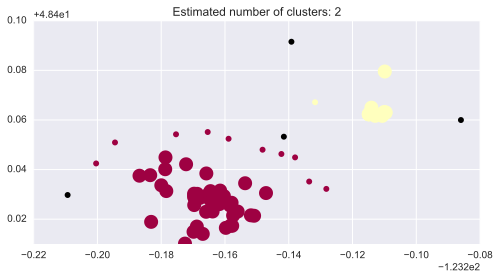

In [85]:
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = theft_m[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = theft_m[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## Part III Theft in Urban Context

In [33]:
fpath = '/Users/marthamorrissey/Documents/STA_project_MM/Data/NeighbourhoodsSHP/Neighbourhoods.shp'

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[-123.3, -123.4, 48.4, 48.47]

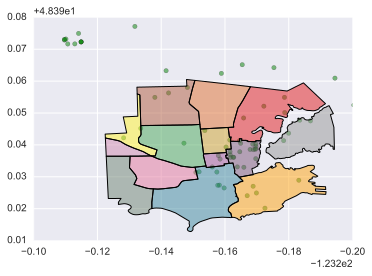

In [88]:
neighborhoods = geopandas.GeoDataFrame.from_file(fpath).replace({-999: None})
neighborhoods2 = neighborhoods.to_crs({'init': 'EPSG:4326'})
neighborhoods2.head()

neighborhoods2.plot('Neighbourh')

test = theft[['longitude', 'latitude']]
test['dbscan'] = labels

#test.head()
geometry = [Point(xy) for xy in zip(test.longitude, test.latitude)]
geo_df = GeoDataFrame(test, crs= {'init' : 'EPSG:4326'}, geometry=geometry)

geo_df.crs = {'init' : 'EPSG: 4326'}

plt.scatter(x=geo_df['longitude'], y=geo_df['latitude'] , alpha = .5, c = 'g')

plt.axis([-123.3, -123.4, 48.4, 48.47])

### Figure 2 in paper

In [89]:
ax2 = geo_df.plot('dbscan', cmap = 'viridis_r', markersize = 6)

mplleaflet.display(fig= ax2.figure, crs= neighborhoods2.crs)

#the two clusters (in space) are shown in teal and purple, the outliers are shown in yellow. 